In [40]:
import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages')

In [41]:
# Run the pip install command below if you don't already have the library
!pip install git+https://github.com/JustAnotherArchivist/snscrape.git

import os
import math
import pandas as pd
import json
from pandas import json_normalize

import snscrape.modules.twitter as sntwitter
import itertools

from datetime import datetime
from random import randrange
import shutil

  Cloning https://github.com/JustAnotherArchivist/snscrape.git to c:\users\rk982\appdata\local\temp\pip-req-build-wp44bfmu


  Running command git clone -q https://github.com/JustAnotherArchivist/snscrape.git 'C:\Users\rk982\AppData\Local\Temp\pip-req-build-wp44bfmu'


# PART 1: Tweet Data Collection

For this project, tweet data collection is broken down into three parts: creating a search parameter, scraping tweets from all counties in a state, and scraping tweets over multiple date ranges. 

## 1.1: Creating Search Parameter

The syntax for our Twitter scraping follows this pattern: ```[TERMS] near:[LOCATION] since:[DATE1] until:[DATE2]```. A new search parameter must be generated for each county and date range. 

We have four general search terms: coronavirus, covid19, pandemic, and quarantine. We want to find tweets that contain at least one of these four terms. Therefore, our ```[TERMS]``` look like this: ```"coronavirus" OR "covid19" OR "pandemic" OR "quarantine"```. To search using different terms or add/remove terms, we can modify that list ```search_terms```. 

```[LOCATION]``` is just the county name, which we take from a CSV for its respective state. ```[DATE1]``` and ```[DATE2]``` are the start date (inclusive) and end date (exclusive) for the search.

As an example, let's say we want to find tweets with any of our search terms in Los Angeles County between January 1st, 2020 and December 31st, 2020. The command would be: ```search_builder(search_terms, "Los Angeles", '2020-01-01', '2021-01-01')```.

The output would be: ```"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2021-01-01```

In [88]:
ST_ABBR = ['ca', 'fl', 'ny', 'tx']

# Search terms: Content in the tweet
search_terms = [
    'coronavirus',
    'covid19',
    'pandemic',
    'quarantine',
]

# Creates a search parameter for the Twitter scraper
# since_date: inclusive
# until_date: exclusive
def search_builder(terms, area, since_date, until_date):    
    s = ''
    # Concatenate all search terms
    for i in range(len(terms) - 1):
        # NOTE: Inclusive OR statement
        s += '\"' + terms[i] + '\" OR '
    s += '\"' + terms[len(terms) - 1] + '\" '    
    
    # Within or the near the area
    s += 'near:\"' + area + '\" '
    # Since the first date
    s += 'since:' + since_date + ' '
    # Until the second date
    s += 'until:' + until_date
    
    return s

# Search for tweets in Los Angeles mentioning COVID terms
# from the beginning to the end of 2020.
los_angeles_search = search_builder(
    search_terms,
    "Los Angeles",
    '2020-01-01',
    '2021-01-01')

print(los_angeles_search)

"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2021-01-01


## 1.2 Save and Scrape by State

We can now scrape tweets from each county in a single state. To do so, we first need all the counties of the state, which can be found in ```data/counties``` in a CSV file (e.g., California counties = ```ca_counties.csv```). Then, we take a county and put it into our search builder along with the search's date range to generate a search parameter. Next, we put the search parameter and maximum number of tweets we want from each county into the tweet scraper, which will return a dataframe. This dataframe called ```county_tweets``` has more information than we need for our project so we only keep the following fields: date, content, renderedContent, user, and hashtags.

After this, we convert ```county_tweets``` into a JSON file following the name pattern ```[COUNTY_NAME].json```. Then, we move the JSON file into its correct subdirectory based on the date range it was scraped from and what state it belongs to. For example, tweets scraped from Alameda County, California between August 1st, 2021 and August 7th, 2021 will be put into a JSON named ```Alameda.json``` and placed into directory ```data/tweets/2021-08-01_2021-08-08/ca_tweets```.

This process will be repeated for all counties in the given state and date range.

In [43]:
# Returns a DataFrame with at most tweet_limit tweets resulting from
# the search
def scrape(search_param, tweet_limit):
    return pd.DataFrame(itertools.islice(
        sntwitter.TwitterSearchScraper(search_param).get_items(), tweet_limit))

# ********* STATE TWEET SCRAPING *********
# state: State to scrape
# abbr: State abbreviation
# limit: Maximum number of tweets to scrape from a county
# since_date: Start date to scrape (inclusive)
# until_date: End date to scrape (exclusive)
# display_all (optional): Display scrape status per county
def state_scraper(state, abbr, limit, since_date, until_date, display_all = False):        
    
    total_tweets = 0

    print("Compiling tweets (max <=" + str(limit) + ") from " + state + " counties from " + since_date + " to " + until_date)

    print("START: " + str(datetime.now()))

    counties = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    for i in range(len(counties)):

        county = counties.iloc[i]['County']
        county.strip()

        county_search = search_builder(
            search_terms,
            county + " County, " + abbr,
            since_date,
            until_date)
        
        county_tweets = scrape(county_search, limit)

        if len(county_tweets) != 0:
            county_tweets = county_tweets[['date', 'content', 'renderedContent', 'user', 'hashtags']]
        
        total_tweets = total_tweets + len(county_tweets)

        # Generates JSON with respective county tweet data
        county_json = county_tweets.to_json(county + ".json", lines=True, orient='records')

        source = os.getcwd() + "/" + county + ".json"
        # Move to respective directory
        destination = '%s/data/tweets/%s_%s/%s_tweets/%s.json' % (os.getcwd(), since_date, until_date, abbr, county)
        shutil.move(source, destination)

        if display_all:
            print('(%d/%d) %s - %d tweets: %s' % (i + 1, len(counties), county, len(county_tweets), str(datetime.now())))
            
    print("END: " + str(datetime.now()))
    print(str(total_tweets) + " tweets processed")

Here are wrapper functions for California, Florida, New York, and Texas tweet scrapers. These exist simply for code readability.

In [ ]:
# California Tweet Scraper
def ca_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("California", "CA", tweet_limit, since_date, until_date, display_all = display_all)

# Florida Tweet Scraper
def fl_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("Florida", "FL", tweet_limit, since_date, until_date, display_all = display_all)

# New York Tweet Scraper
def ny_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("New York", "NY", tweet_limit, since_date, until_date, display_all = display_all)
    
# Texas Tweet Scraper
def tx_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("Texas", "TX", tweet_limit, since_date, until_date, display_all = display_all)

The function ```scrape_all``` performs two important tasks. Firstly, it creates the date range directory that will hold the state subdirectories, which hold all the county tweets. Second, it calls the four defined state scrapers, which will save the county tweets in the directories previously stated. 

In [ ]:
# Scrape all selected states
def scrape_all(tweet_limit, since_date, until_date, display_all = False):
    
    try:
        # Create date range directory
        os.mkdir('data/tweets/%s_%s' % (since_date, until_date))
        
        print("Directory for range %s to %s does not exist. Creating now and populating..." % (since_date, until_date))

        # Create California subdirectory
        os.mkdir('data/tweets/%s_%s/ca_tweets' % (since_date, until_date))
        # Create Florida subdirectory
        os.mkdir('data/tweets/%s_%s/fl_tweets' % (since_date, until_date))
        # Create New York subdirectory
        os.mkdir('data/tweets/%s_%s/ny_tweets' % (since_date, until_date))
        # Create Texas subdirectory
        os.mkdir('data/tweets/%s_%s/tx_tweets' % (since_date, until_date))
    except FileExistsError:
        print("Directory for range %s to %s already exists." % (since_date, until_date))

    ca_scraper(tweet_limit, since_date, until_date, display_all = display_all)
    fl_scraper(tweet_limit, since_date, until_date, display_all = display_all)
    ny_scraper(tweet_limit, since_date, until_date, display_all = display_all)
    tx_scraper(tweet_limit, since_date, until_date, display_all = display_all)

## 1.3 Scraping over Date Ranges

We've gone over search terms and locations. Now, we need to incorporate the date range. Our team has decided to scrape nine weeks worth of tweets between August 1st, 2021 to December 10th, 2021. To achieve this, we define a lower bound date ```current_start``` and upper bound date ```current_end```, scrape all states using this range, then move the boundaries up by seven days. This process results in over two million tweets getting scraped and filed into nine date range directories and four state directories per date range.

In [44]:
#----- WARNING------------------------------------------------------------------
# RUNNING THIS CELL WILL START DATA COLLECTION. 
# RUNTIME = ~12 HOURS
#----- WARNING------------------------------------------------------------------

from datetime import timedelta

start_time = datetime.strptime("2021-08-01", "%Y-%m-%d")
end_time = datetime.strptime("2021-08-08", "%Y-%m-%d")

weeks_count = 8

# Scrape tweets from 08/01 to 09/26
for i in range(weeks_count):
    
    current_start = (start_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    current_end = (end_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    
    # Scrape 1000 tweets from each county of each state
    scrape_all(1000, current_start, current_end)

Directory for range 2021-08-01 to 2021-08-08 already exists.
Compiling tweets (max <=1000) from California counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 22:45:21.929392
END: 2021-12-13 22:49:52.254917
11337 tweets processed
Compiling tweets (max <=1000) from Florida counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 22:49:52.256917
END: 2021-12-13 22:55:54.427091
15639 tweets processed
Compiling tweets (max <=1000) from New York counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 22:55:54.429094
END: 2021-12-13 23:02:20.789729
15682 tweets processed
Compiling tweets (max <=1000) from Texas counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 23:02:20.791727
END: 2021-12-14 00:11:28.287382
207660 tweets processed
Directory for range 2021-08-08 to 2021-08-15 already exists.
Compiling tweets (max <=1000) from California counties from 2021-08-08 to 2021-08-15
START: 2021-12-14 00:11:28.290381
END: 2021-12-14 00:16:19.258796
11342 tweets processed
Compiling tweets 

In [90]:
#----- WARNING------------------------------------------------------------------
# RUNNING THIS CELL WILL START DATA COLLECTION. 
# RUNTIME = ~1 HOURS
#----- WARNING------------------------------------------------------------------

# One more week for 2 million entries
# Scrape from 09/26 to 10/03 

current_start = (start_time + timedelta(days = 8 * 7)).strftime("%Y-%m-%d")
current_end = (end_time + timedelta(days = 8 * 7)).strftime("%Y-%m-%d")
    
# Scrape 1000 tweets from each county of each state
scrape_all(1000, current_start, current_end)

Directory for range 2021-09-26 to 2021-10-03 already exists.
Compiling tweets (max <=1000) from California counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 14:49:45.425344
END: 2021-12-14 14:54:52.643010
11212 tweets processed
Compiling tweets (max <=1000) from Florida counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 14:54:52.645012
END: 2021-12-14 15:01:11.346188
15372 tweets processed
Compiling tweets (max <=1000) from New York counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 15:01:11.348183
END: 2021-12-14 15:07:36.329638
15286 tweets processed
Compiling tweets (max <=1000) from Texas counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 15:07:36.331634
END: 2021-12-14 16:18:25.143407
207299 tweets processed


The snippet below sums up all the tweets scraped across all states. We have gathered 2,248,336 tweets mentioning COVID-19 across California, Florida, New York, and Texas. 

In [91]:
counties = {}

for abbr in ST_ABBR:
    
    csv = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    counties[abbr] = []
    
    for i in range(len(csv)):

        county = csv.iloc[i]['County']
        county.strip()
        
        counties[abbr].append(county)
                
start_time = datetime.strptime("2021-08-01", "%Y-%m-%d")
end_time = datetime.strptime("2021-08-08", "%Y-%m-%d")

range_total = 0
total_tweets = 0

weeks_count = 9

for i in range(weeks_count):
    
    range_total = 0
    
    current_start = (start_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    current_end = (end_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    
    for abbr in ST_ABBR:
        
        for county in counties[abbr]:
            for line in open('data/tweets/%s_%s/%s_tweets/%s.json' % (current_start, current_end, abbr, county)):
                range_total += 1
                total_tweets += 1
    print('%s to %s tweets = %d' % (current_start, current_end, range_total))
    
print('Total tweets = %d' % total_tweets)       

2021-08-01 to 2021-08-08 tweets = 250394
2021-08-08 to 2021-08-15 tweets = 250597
2021-08-15 to 2021-08-22 tweets = 249925
2021-08-22 to 2021-08-29 tweets = 250056
2021-08-29 to 2021-09-05 tweets = 249586
2021-09-05 to 2021-09-12 tweets = 249439
2021-09-12 to 2021-09-19 tweets = 249623
2021-09-19 to 2021-09-26 tweets = 249460
2021-09-26 to 2021-10-03 tweets = 249256
Total tweets = 2248336


In [92]:
# Branch-2-Keywords testing json to pandas dataframes
import re
# Code taken from Professor Mahdi slides. [Should update which slides this is from later.]
def clean_content(content_line):
    digit_removal = re.sub('\d+', '', content_line)
    punctuation_removal = re.sub('[\W]+', ' ', digit_removal)
    return punctuation_removal.upper().split()  

def file_paths(path):
    # Stack overflow solution to finding only files in a directory using os.walk, previous attempt used listdir.
    # Article: https://stackoverflow.com/questions/52338706/isadirectoryerror-errno-21-is-a-directory-it-is-a-file
    path_list = [os.path.join(path, file) 
                      for path, directory, files in os.walk(path) for file in files]
    return path_list

# Combine JSON files for efficiency then make a single dataframe.

# Take tweet from tweet folder.
# since_date: First part of date directory
# until_date: Second part of date directory
# state_abbr: Which state to mash together
def json_to_dataFrame(since_date, until_date, state_abbr):
    file_path_list = file_paths('data/tweets/%s_%s/%s_tweets' % (since_date, until_date, state_abbr))
    combined_json_file = 'data/tweets/%s_%s/%s_result.json' % (since_date, until_date, state_abbr)
# Stack overflow solution for combining json files. Combining json files was suggested as more efficient than
#  dataframes. Combines the json files into record oreint/format. 
# Article: https://stackoverflow.com/questions/23520542/issue-with-merging-multiple-json-files-in-python
    with open(combined_json_file, 'w') as combined_files:
        combined_files.write("{}".format("".join([open(file, "r").read() for file in file_path_list])))
# Dataframe using orient records because this was the specific formating used to collect the data. 
    dataframe = pd.read_json(combined_json_file, lines=True, orient='records')

    os.remove(combined_json_file)
    
    return dataframe

In [93]:
tweet_results = {}
# Use the start and end dates as the key. Create a subdictionary which will hold state results for that time frame.
tweet_results[('2021-08-01', '2021-08-08')] = {}

for abbr in ST_ABBR:
    tweet_results[('2021-08-01', '2021-08-08')][abbr] = json_to_dataFrame('2021-08-01', '2021-08-08', abbr)
    
ca_df = tweet_results[('2021-08-01', '2021-08-08')]['ca']

ca_df

,date,content,renderedContent,user,hashtags
0,2021-08-07 23:34:25,@hkanji @oneunderscore__ Some of the people wh...,@hkanji @oneunderscore__ Some of the people wh...,"{'username': 'doritmi', 'id': 54886540, 'displ...","[COVID19, vaccines]"
1,2021-08-07 20:55:01,YOU TELL THEM @GovMurphy! America as a whole w...,YOU TELL THEM @GovMurphy! America as a whole w...,"{'username': 'OmidIranmanesh', 'id': 357994519...","[GovernorMurphy, GetVaccinatedNow]"
2,2021-08-07 15:20:37,@chickaboy @BoastIra @anthonycookppc @mcfunny ...,@chickaboy @BoastIra @anthonycookppc @mcfunny ...,"{'username': 'doritmi', 'id': 54886540, 'displ...",[COVID19]
3,2021-08-07 11:09:28,In TX if you have a school aged child Greg Abb...,In TX if you have a school aged child Greg Abb...,"{'username': 'CeSpeaks', 'id': 15212751, 'disp...",[COVID19]
4,2021-08-06 21:59:55,Curious if a #journorequest led to info about ...,Curious if a #journorequest led to info about ...,"{'username': 'sewrighter', 'id': 40761617, 'di...","[journorequest, Airlines, COVID19]"
...,...,...,...,...,...
11332,2021-08-07 23:46:00,不謹慎ではあるが、本人たちにCovid19を強制的感染させて苦しんでもらう方法はないのかなと...,不謹慎ではあるが、本人たちにCovid19を強制的感染させて苦しんでもらう方法はないのかなと...,"{'username': 'KosukeShinoda', 'id': 5573062, '...",None
11333,2021-08-07 23:46:00,@Acyn They have the audacity to say Biden’s pa...,@Acyn They have the audacity to say Biden’s pa...,"{'username': 'Danty99805058', 'id': 1112005674...",None
11334,2021-08-07 23:45:59,@GOPLeader It's the pandemic. Quit blaming eve...,@GOPLeader It's the pandemic. Quit blaming eve...,"{'username': 'Elaine24402195', 'id': 133889864...",None
11335,2021-08-07 23:45:59,In home quarantine - 7 of 14 days. Not complai...,In home quarantine - 7 of 14 days. Not complai...,"{'username': 'minor_little', 'id': 14228730446...",None


In [120]:
# Sentiment testing with HuggingFace
# Pip install the transfomers with Pytorch specifically. 
# !pip install transformers[torch]
from transformers import pipeline

def sentiment_analysis(dataframe):
    # Added print timeframe from State Scrapper
    print("START: " + str(datetime.datetime.now())[11:16])
    
    # Construct pipeline using sentiment-analysis to mesaure "sentiment" of tweet content
    classifier = pipeline("sentiment-analysis")

    # Create empty list to collect sentiment values
    sentiment_list = []
    # For loop to take twitter content and analyze for sentiment values.
    for content in ca_df['content']:
        content_sentiment = classifier(content)
        # # Formated sentiment score
        # content_sentiment[0]['score'] = "{:.2f}%".format(content_sentiment[0]['score'] * 100)
        # # Append each new content sentiment to the list.
        # sentiment_list.append(content_sentiment[0])
        sentiment_list.append(content_sentiment[0]['label'])
        
    # Copy dataframe
    df_copy = dataframe.copy()
    
    # Added print timeframe from State Scrapper
    print("End: " + str(datetime.datetime.now())[11:16])
    
    # assign the new sentiment list values to the dataframe titled sentiment
    return df_copy.assign(sentiment = sentiment_list)

test_ca_df = sentiment_analysis(ca_df)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


START: 16:39
End: 16:53


In [122]:
# Fix date column to remove time from datetime for data visualization
def datetime_to_date(dataframe2):
    print("Start: " + str(datetime.datetime.now())[11:])
    df2_copy = dataframe2.copy()
    datetime_list = []
    for dt in dataframe2['date']:
         datetime_list.append(dt.date())
    new_date = pd.DataFrame(data={'date' : datetime_list})
    df2_copy['date'] = new_date['date']
    print("End: " + str(datetime.datetime.now())[11:])
    return df2_copy

date_formatted_df = datetime_to_date(test_ca_df)

Start: 16:54:13.358799
End: 16:54:13.397811


In [123]:
# Testing how many tweets were identified as 'positive' which may be an interesting insight to the accuracy of the 
#  sentiment analysis. Compare the content to ensure true positive sentiment and not sarcastic senitments.
date_formatted_df.loc[date_formatted_df['sentiment']=='NEGATIVE']

,date,content,renderedContent,user,hashtags,sentiment
0,2021-08-07,@hkanji @oneunderscore__ Some of the people wh...,@hkanji @oneunderscore__ Some of the people wh...,"{'username': 'doritmi', 'id': 54886540, 'displ...","[COVID19, vaccines]",NEGATIVE
2,2021-08-07,@chickaboy @BoastIra @anthonycookppc @mcfunny ...,@chickaboy @BoastIra @anthonycookppc @mcfunny ...,"{'username': 'doritmi', 'id': 54886540, 'displ...",[COVID19],NEGATIVE
3,2021-08-07,In TX if you have a school aged child Greg Abb...,In TX if you have a school aged child Greg Abb...,"{'username': 'CeSpeaks', 'id': 15212751, 'disp...",[COVID19],NEGATIVE
4,2021-08-06,Curious if a #journorequest led to info about ...,Curious if a #journorequest led to info about ...,"{'username': 'sewrighter', 'id': 40761617, 'di...","[journorequest, Airlines, COVID19]",NEGATIVE
5,2021-08-06,El WR Jauan Jennings y CB Emmanuel Moseley han...,El WR Jauan Jennings y CB Emmanuel Moseley han...,"{'username': 'mayralgomez', 'id': 248390007, '...","[Covid19, NFL]",NEGATIVE
...,...,...,...,...,...,...
11331,2021-08-07,you just know the Scrubs pandemic storyline wo...,you just know the Scrubs pandemic storyline wo...,"{'username': 'upstartgeek', 'id': 773983964423...",None,NEGATIVE
11332,2021-08-07,不謹慎ではあるが、本人たちにCovid19を強制的感染させて苦しんでもらう方法はないのかなと...,不謹慎ではあるが、本人たちにCovid19を強制的感染させて苦しんでもらう方法はないのかなと...,"{'username': 'KosukeShinoda', 'id': 5573062, '...",None,NEGATIVE
11333,2021-08-07,@Acyn They have the audacity to say Biden’s pa...,@Acyn They have the audacity to say Biden’s pa...,"{'username': 'Danty99805058', 'id': 1112005674...",None,NEGATIVE
11334,2021-08-07,@GOPLeader It's the pandemic. Quit blaming eve...,@GOPLeader It's the pandemic. Quit blaming eve...,"{'username': 'Elaine24402195', 'id': 133889864...",None,NEGATIVE


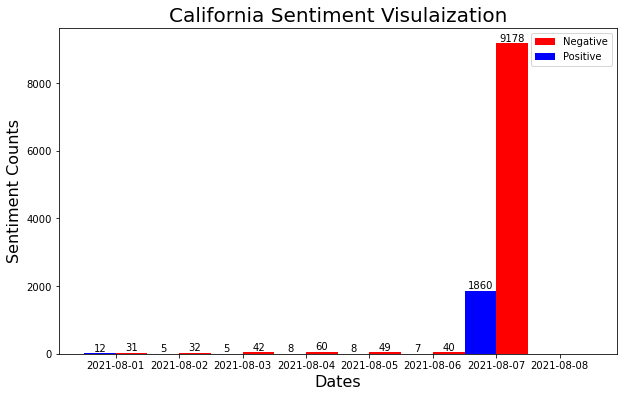

In [124]:
import matplotlib.pyplot as plt
import datetime

list_of_dates = []
negative_x = []
x_tick_labels = []
# Visualizes data based on formatted dataframes for date and sentiment...
def sentiment_visualization(date_foramtted_df, state):
    # Seperate the data based on sentiment.
    neg_sentiment_df = date_formatted_df.loc[date_formatted_df['sentiment']=='NEGATIVE']
    pos_sentiment_df = date_formatted_df.loc[date_formatted_df['sentiment']=='POSITIVE']
    # Collect unique date values
    neg_set_of_dates = set(neg_sentiment_df['date'])
    pos_set_of_dates = set(pos_sentiment_df['date'])
    set_of_dates = neg_set_of_dates.union(pos_set_of_dates)
    # added an additional date value at the end to assist in visualization issues during development.
    set_of_dates.add(max(set_of_dates) + datetime.timedelta(days=1))
    # Sort dates
    list_of_dates = sorted(list(set_of_dates))
    # Create X and Y values lists for Negative sentiments.
    negative_x = []
    negative_y = []
    for i in range(len(list_of_dates)):
        x_value = i+1 
        y_value = len(neg_sentiment_df.loc[date_formatted_df['date'] == list_of_dates[i]])
        negative_x.append(x_value)
        negative_y.append(y_value)
    # Create X and Y values lists for Positive sentiments.
    positive_x = []
    positive_y = []
    for i in range(len(list_of_dates)):
        x_value = (i+1) - 0.5 
        y_value = len(pos_sentiment_df.loc[date_formatted_df['date'] == list_of_dates[i]])
        positive_x.append(x_value)
        positive_y.append(y_value)
        
    
    # Reference: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-
    # the-bar-on-each-bar-with-pyplot-barh
    # User: Franck Dernoncourt
    # Code referenced for textual values in the bar graph
    
    # Create plot and assign figure size
    fig, axs = plt.subplots(figsize=(10,6))
    # Convert datetime dates to strings to assign to the 'x ticks' on the plot graph
    x_tick_labels = []
    for date in list_of_dates:
        x_tick_labels.append(str(date))
    # General bar width
    bar_widths = 0.5
    # Seperatly creating both bar plots and assign to the same subplot
    negative_bar = axs.bar(negative_x, negative_y, width=bar_widths, align='edge', color='red', label='Negative')
    positive_bar = axs.bar(positive_x, positive_y, width=bar_widths, align='edge', color='blue', label='Positive')
    # Label bar graph values
    barlabels(negative_bar, axs)
    barlabels(positive_bar, axs)
    # Label x tick values
    plt.xticks(negative_x, x_tick_labels)
    axs.set_title((state + ' Sentiment Visulaization'), fontsize=20)
    axs.set_xlabel('Dates', fontsize=16)
    axs.set_ylabel('Sentiment Counts', fontsize=16)
    plt.legend()
    plt.show()
    return list_of_dates, negative_x, x_tick_labels
# Function used to label the bar graph values 
def barlabels(bar_graph, axs):
    for bar in bar_graph:
        if bar.get_height() > 0:
            bar_height = bar.get_height()
            axs.text(bar.get_x() + bar.get_width()/2, bar_height, '%d' % int(bar_height),
                     ha='center', va='bottom')

# New Function call
list_of_dates, negative_x, x_tick_labels = sentiment_visualization(date_formatted_df, 'California')

In [128]:
pos_count = 0
neg_count = 0
pos_rate = 0

# use positive and negative label to create a positivity count and negativity count
for i in range(int(test_ca_df.size / 6)):
    if test_ca_df.iloc[i]['sentiment'] == 'POSITIVE':
        pos_count += 1
    else:
        neg_count += 1
        
# function to create positivity rating using counts
pos_rate = pos_count/(pos_count + neg_count)
percent = "{:.0%}".format(pos_rate)
print(pos_count)
print(neg_count)
print(percent)

1905
9432
17%


C:\Users\rk982\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


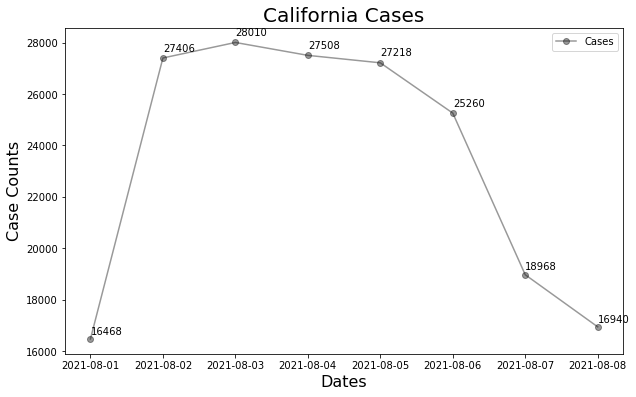

In [139]:
# Attempt at Loading Covid-19 data
# Load California Covid 19 Cases data by county
ca_covid_df = pd.read_csv("data/covid_data/covid19cases_test.csv")
# Drop majority of columns 
ca_covid_df = ca_covid_df.drop(['area_type', 'cumulative_cases', 'cumulative_deaths',
                                'cumulative_total_tests', 'cumulative_positive_tests', 
                                'cumulative_reported_cases', 'cumulative_reported_deaths'], axis=1)
# Read counties csv
counties = pd.read_csv("data/counties/ca_counties.csv")
cases_list = []
# Iterate through the list of days 
for date in list_of_dates:
# Select data based on a day
    formatted_covid_df = ca_covid_df[ca_covid_df['date'].isin([str(date)])]
# Select data based on each county's for the selected day
    county_covid_cases = formatted_covid_df[formatted_covid_df['area'].isin(list(counties['County']))]
# Summarize the number all of the cases that day

    cases_list.append(sum([float(x) for x in county_covid_cases['cases']]))
        
# Testing graphical output of matplotlib... 
fig2, axs2 = plt.subplots(figsize=(10,6))
# Line Graph version
cases_line = axs2.plot(negative_x, cases_list, 'o-', alpha=0.4, color='black', label='Cases')
# Reference: https://stackoverflow.com/questions/22272081/label-python-data-points-on-plot
# User: falsetru
for point in range(len(list_of_dates)):
    axs2.annotate('%d' % int(cases_list[point]), xy=((point+1), 1.01*cases_list[point]))
# # Bar Graph equivalence.
# cases_bar = axs2.bar(negative_x, cases_list, width= 0.5, alpha=0.4, color='black', label='Cases')
# barlabels(cases_bar, axs2)

axs2.set_title('California Cases', fontsize=20)
axs2.set_xlabel('Dates', fontsize=16)
axs2.set_ylabel('Case Counts', fontsize=16)
plt.xticks(negative_x, x_tick_labels)
plt.legend()
plt.show()

In [140]:
import pandas as pd

In [145]:
marin_temp = pd.read_json("data/tweets/2021-08-01_2021-08-08/ca_tweets/Marin.json", lines = True)

marin = marin_temp[['renderedContent', 'hashtags']]

# marin = marin_temp.drop(columns={'url', 'date', 'content', 'id', 'user', 'replyCount',
#        'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang',
#        'source', 'sourceUrl', 'sourceLabel', 'outlinks', 'tcooutlinks',
#        'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
#        'inReplyToUser', 'mentionedUsers', 'coordinates', 'place',
#        'cashtags'})

print(marin.columns)


# apply filter method to find out tone of tweet, for brevity consider the temporary column 'tone'
marin['tone'] = [3, 4, 5, 2, 2, 4, 2]

Index(['renderedContent', 'hashtags'], dtype='object')


<ipython-input-145-f4227c72497c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marin['tone'] = [3, 4, 5, 2, 2, 4, 2]


# References

California Counties: https://www.mapsofworld.com/usa/states/california/california-county-map.html

Florida Counties: https://www.mapsofworld.com/usa/states/florida/florida-county-map.html

New York Counties: https://www.mapsofworld.com/usa/states/new-york/new-york-county-map.html

Texas Counties: https://www.mapsofworld.com/usa/states/texas/texas-county-map.html